# ERPs Analysis
In this notebook, we take the MATLAB files containing each subject's trials ERPs average per category. We analyse it to find the differences in hiher and lower peak latency across categories after stimulus onset.

### 1. Load data

In [55]:
from os.path import dirname, join as pjoin
import scipy.io as sio
from operator import itemgetter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import argrelextrema

import pandas as pd
import pyxdf
#import dataframe_image as dfi
import seaborn as sns

In [91]:
data_path  = "data/erps"
erps_file = pjoin(data_path, "mean_activation_all_2_sub_PO8.mat")
erps_content = sio.loadmat(erps_file)

In [92]:
ch_keys = ["erps_body", "erps_face", "erps_object"]
all_keys = ch_keys.copy()
all_keys.append("subj_time")
df = pd.DataFrame(columns=np.concatenate([all_keys]))

# Extract data for each participant, as many as there are time series
participant_count = len(dict(erps_content)["subj_time"])
for participant in range(participant_count):
    df_participant = pd.DataFrame()
    # Extract all keys into dataframe columns
    for key in all_keys:
        series_array = dict(erps_content)[key]
        df_participant[key] = pd.Series(series_array[participant])
    df_participant['subject'] = participant

    # Add full participant extraction to final dataframe
    df = pd.concat([df, df_participant], ignore_index=True)

df

,erps_body,erps_face,erps_object,subj_time,subject
0,-0.567869,0.079098,-0.952857,-199.218750,0.0
1,-0.227522,0.268502,-0.757960,-197.265625,0.0
2,-0.072050,0.559938,-0.429319,-195.312500,0.0
3,0.189135,0.820012,-0.268251,-193.359375,0.0
4,0.305856,1.126550,-0.250736,-191.406250,0.0
...,...,...,...,...,...
711,6.025119,4.737582,5.947699,490.234375,1.0
712,6.056966,4.752133,6.108863,492.187500,1.0
713,5.813677,4.867718,6.330539,494.140625,1.0
714,5.878787,5.195728,6.282629,496.093750,1.0


In [93]:
# df2 = df[["erps_body","erps_face","erps_object","subj_time"]]
# by melting the df this way, I can easy plot the 'variable' columns that contains all categories
df2 = df.melt(id_vars=["subj_time","subject"])
df2

,subj_time,subject,variable,value
0,-199.218750,0.0,erps_body,-0.567869
1,-197.265625,0.0,erps_body,-0.227522
2,-195.312500,0.0,erps_body,-0.072050
3,-193.359375,0.0,erps_body,0.189135
4,-191.406250,0.0,erps_body,0.305856
...,...,...,...,...
2143,490.234375,1.0,erps_object,5.947699
2144,492.187500,1.0,erps_object,6.108863
2145,494.140625,1.0,erps_object,6.330539
2146,496.093750,1.0,erps_object,6.282629


<AxesSubplot:xlabel='subj_time', ylabel='value'>

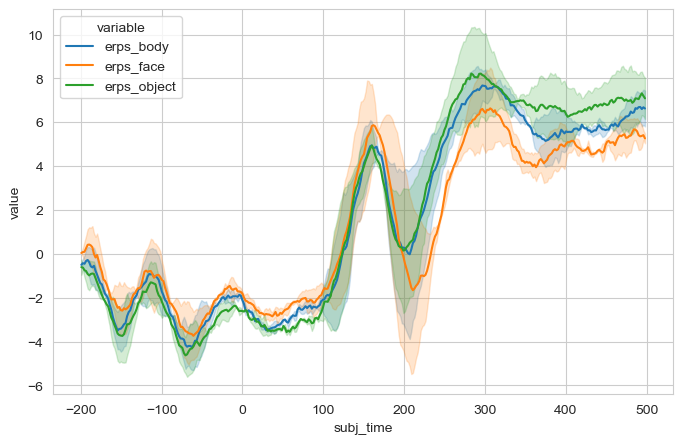

In [94]:
fig, ax = plt.subplots(nrows=1, figsize=(8, 5))
# time_window = df.loc[df['subject'] == 1, 'sub_time']
# time_window
sns.lineplot(data= df2, x='subj_time', y='value', hue='variable')
# sns.lineplot(data= df, x='subj_time', y='erps_object')

### 2. Create time windows to calculate max and min peak

In [64]:
n = 10  # number of points to be checked before and after
find_gradient_extrema_start_time = 0 # start to look for gradient extrema
find_gradient_extrema_end_time = 200

# Clean up old dataframe before making a copy
if 'df3' in locals():
    del df3
df3 = df

# Calculate local maxima and minima
for key in ch_keys:
    df3[key+'_min'] = df3.iloc[argrelextrema(df3[key].values, np.less_equal, order=n)[0]][key]
    df3[key+'_max'] = df3.iloc[argrelextrema(df3[key].values, np.greater_equal, order=n)[0]][key]

    # Calculate gradients, i.e., slops of the data; hypotheis: first stepest upwards gradient is where the time window for the max / min should be looked for
    df3[key+'_grads'] = np.gradient(df3[key])
    grads_extrema = []
    for participant in range(participant_count):
        df3_part = df3[(df3['subject'] == participant) & # select particpant
                       (df3['subj_time'] > find_gradient_extrema_start_time) & # select start time to find gradient extrema
                       (df3['subj_time'] <= find_gradient_extrema_end_time)] # select end time to find graident extrema
        df3_part[key+'_grads'] = np.gradient(df3_part[key])
        # Find extrema (min max) per participant
        grads_extrema.append(df3_part[key+"_grads"].idxmin())
        grads_extrema.append(df3_part[key+"_grads"].idxmax())

    # Store all gradient extrema back into the pandas dataframe
    df3[key+'_grads_extrema'] = df3.iloc[np.array(grads_extrema)][key+"_grads"]

df3

/var/folders/yy/s3wgmwl10fg_cc7cb_s92snr0000gn/T/ipykernel_40610/103591817.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_part[key+'_grads'] = np.gradient(df3_part[key])


,erps_body,erps_face,erps_object,subj_time,subject,erps_body_min,erps_body_max,erps_body_grads,erps_body_grads_extrema,erps_face_min,erps_face_max,erps_face_grads,erps_face_grads_extrema,erps_object_min,erps_object_max,erps_object_grads,erps_object_grads_extrema
0,5.915901,6.110841,5.858163,-199.218750,0.0,5.915901,NaN,0.172680,NaN,6.110841,NaN,0.346153,NaN,5.858163,NaN,0.282465,NaN
1,6.088581,6.456994,6.140627,-197.265625,0.0,NaN,NaN,0.111870,NaN,NaN,NaN,0.247638,NaN,NaN,NaN,0.295131,NaN
2,6.139641,6.606117,6.448425,-195.312500,0.0,NaN,NaN,0.252557,NaN,NaN,NaN,0.166883,NaN,NaN,NaN,0.159765,NaN
3,6.593696,6.790761,6.460158,-193.359375,0.0,NaN,NaN,0.225179,NaN,NaN,NaN,0.255691,NaN,NaN,NaN,0.098451,NaN
4,6.589998,7.117500,6.645327,-191.406250,0.0,NaN,NaN,0.072983,NaN,NaN,NaN,0.212455,NaN,NaN,NaN,0.168954,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,5.010485,5.210922,4.485417,490.234375,7.0,NaN,NaN,-0.024598,NaN,NaN,NaN,0.050127,NaN,NaN,NaN,-0.074956,NaN
2860,5.001881,5.355083,4.451282,492.187500,7.0,NaN,NaN,0.016314,NaN,NaN,5.355083,0.022650,NaN,4.451282,NaN,0.073568,NaN
2861,5.043113,5.256223,4.632553,494.140625,7.0,NaN,NaN,0.027653,NaN,NaN,NaN,-0.149143,NaN,NaN,NaN,0.228540,NaN
2862,5.057186,5.056796,4.908361,496.093750,7.0,NaN,NaN,-0.150750,NaN,NaN,NaN,-0.040566,NaN,NaN,NaN,0.145819,NaN


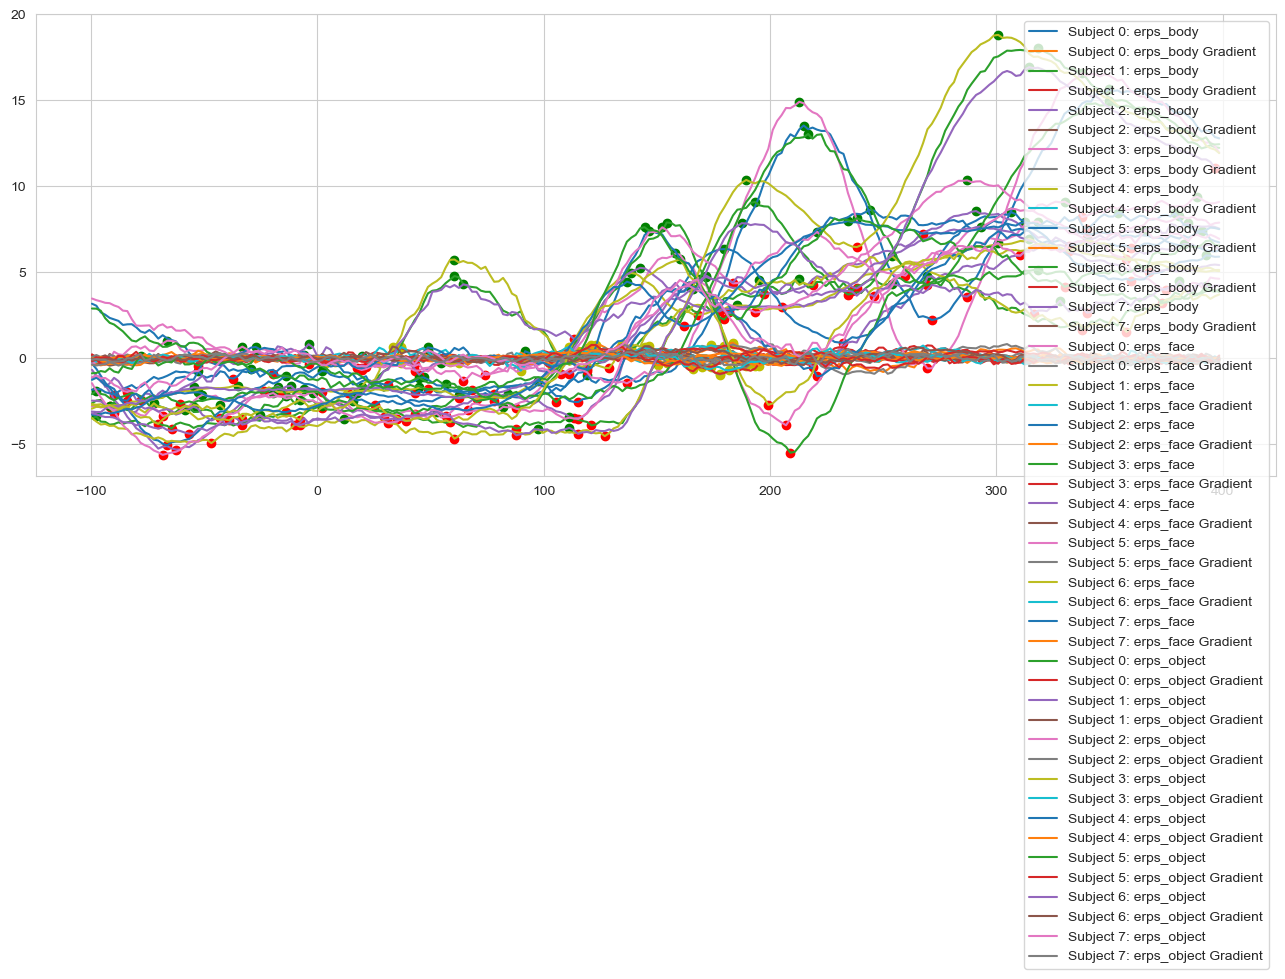

In [65]:
# Plot results
global_time_window_start = -100
global_time_window_end = 400

plt.figure(figsize=(16,6))
for key in ch_keys:
    for participant in range(participant_count):
        df4 = df3[df3['subject'] == participant] # select participant
        df4 = df4[(df4['subj_time'] > global_time_window_start) & (df4['subj_time'] < global_time_window_end)] # select time window
        plt.scatter(df4.subj_time, df4[key+'_min'], c='r')
        plt.scatter(df4.subj_time, df4[key+'_max'], c='g')
        line, = plt.plot(df4.subj_time, df4[key])
        line.set_label(f"Subject {participant}: {key}")

        # # Also print gradients and their extrema
        plt.scatter(df4.subj_time, df4[key+'_grads_extrema'], c='y')
        line, = plt.plot(df4.subj_time, df4[key+'_grads'])
        line.set_label(f"Subject {participant}: {key} Gradient")

plt.legend()
plt.show()

Subject 0, key erps_body has minimum 2.2399916648864746 and maximum 13.544217109680176
Subject 1, key erps_body has minimum -0.7455092668533325 and maximum 4.79033088684082
Subject 2, key erps_body has minimum 3.7351179122924805 and maximum 4.731099605560303
Subject 3, key erps_body has minimum -3.881314516067505 and maximum 6.104855537414551
ERROR: Subject 4, key erps_body has 1 minimums and 2 maximums
Subject 5, key erps_body has minimum 2.687896251678467 and maximum 7.39567756652832
Subject 6, key erps_body has minimum 3.719270944595337 and maximum 9.096206665039062
Subject 7, key erps_body has minimum -0.5057152509689331 and maximum 4.0622687339782715
Subject 0, key erps_face has minimum -0.5760124325752258 and maximum 14.922928810119629
Subject 1, key erps_face has minimum -0.5618327260017395 and maximum 5.753466606140137
Subject 2, key erps_face has minimum 0.9126566648483276 and maximum 6.3574323654174805
Subject 3, key erps_face has minimum -5.477518558502197 and maximum 7.9058

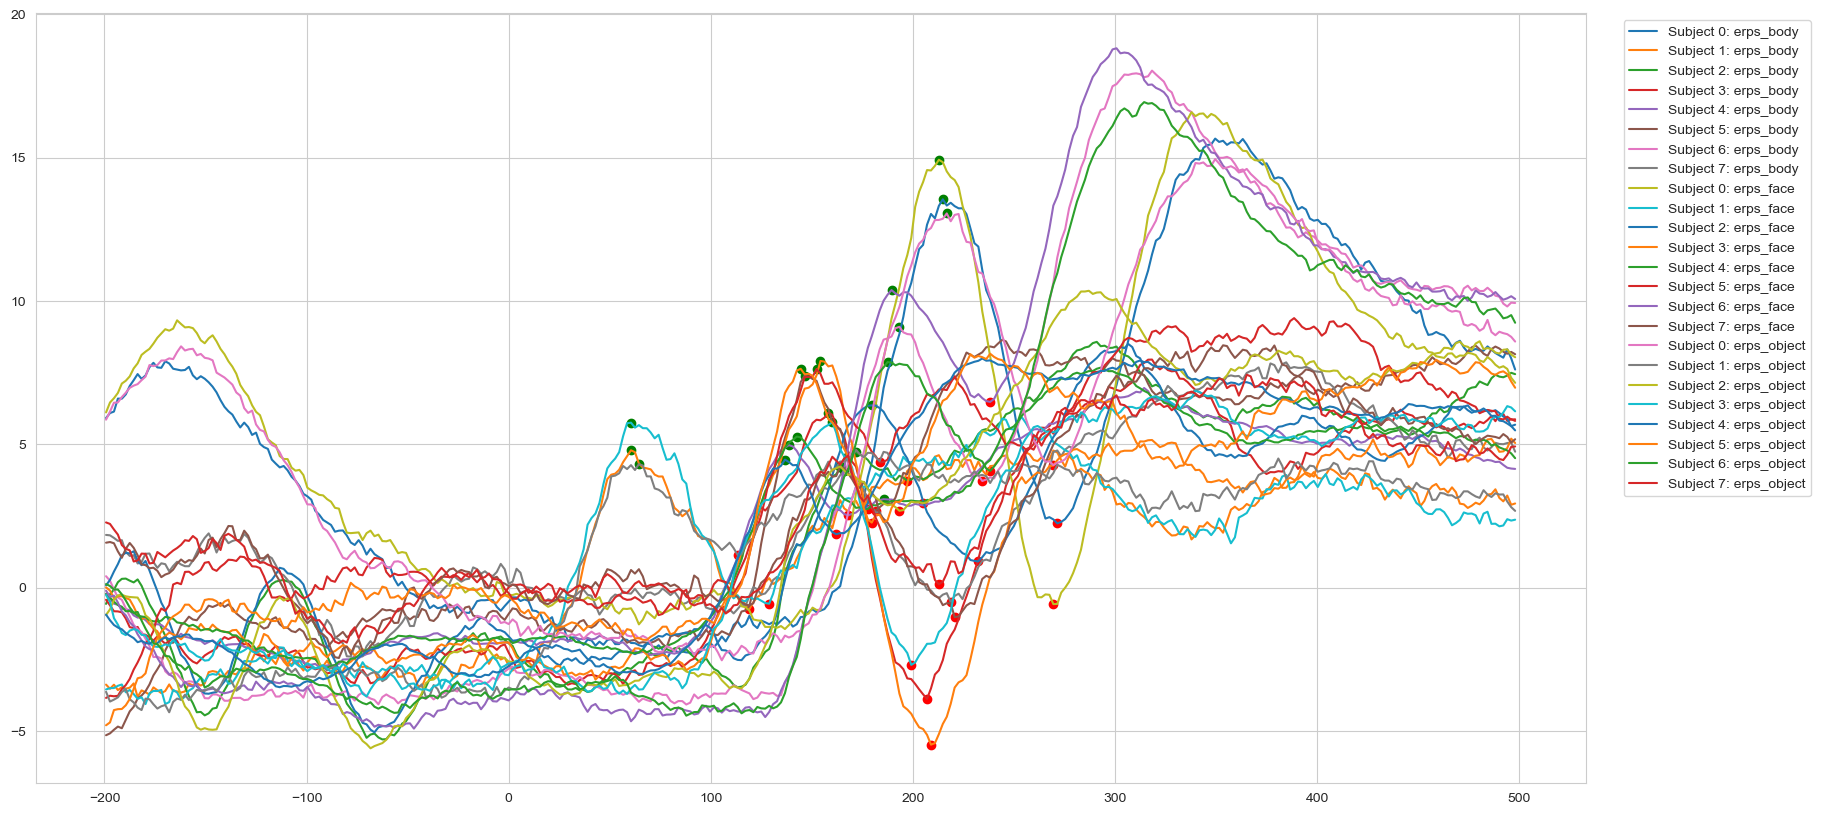

,subject,key,min,max
0,0,erps_body,2.239992,13.544217
1,1,erps_body,-0.745509,4.790331
2,2,erps_body,3.735118,4.731100
3,3,erps_body,-3.881315,6.104856
4,5,erps_body,2.687896,7.395678
5,6,erps_body,3.719271,9.096207
6,7,erps_body,-0.505715,4.062269
7,0,erps_face,-0.576012,14.922929
8,1,erps_face,-0.561833,5.753467
9,2,erps_face,0.912657,6.357432


,min,max
key,,
erps_body,1.035677,7.103522
erps_face,0.586895,8.166972
erps_object,1.714381,6.491597


In [85]:
window_length = 100 # length of the time window in milliseconds after the steepest ascent to look for the max and then min
df_min_max = pd.DataFrame(columns=['subject', 'key', 'min', 'max'])
plt.figure(figsize=(20,10))
for key in ch_keys:
    for participant in range(participant_count):
        ## Step 1: find the local time frame
        df4 = df3[(df3['subject'] == participant) & # Select the participant
                  (df3['subj_time'] > global_time_window_start) & (df3['subj_time'] < global_time_window_end)] # Select the global time window to search in
        df4.reset_index(inplace=True)

        # Get participant absolute maxima
        absolute_max_time = df4.iloc[np.array([df4[key + '_grads_extrema'].idxmax()])]['subj_time'].iloc[0]
        local_time_window_start = absolute_max_time
        local_time_window_end = absolute_max_time + window_length

        ## Step 2: find the min + max with the seleted window
        # Define the time window to look in for minima and maxima based on the grad maxima
        df4 = df3[(df3['subject'] == participant) & # Select the participant
                  (df3['subj_time'] > local_time_window_start) & (df3['subj_time'] < local_time_window_end)] # Select the time window to look in

        # Get participant absolute minima and maxima within the selected time frame (also the count)
        min = df4[key + '_min'].min()
        max = df4[key + '_max'].min()
        min_count = df4[key + '_min'].count()
        max_count = df4[key + '_max'].count()

        ## Step 3: If all goes right, add the min + max to the resulting data frame
        if min_count == 1 and max_count == 1:
            # If everything is good, this should give EXACTLY one min and one max; so this can be added to the overall array for aggregation
            print(f"Subject {participant}, key {key} has minimum {min} and maximum {max}")
            d = {'subject': [participant], 'key': [key], 'min': [min], 'max': [max]}
            df_min_max = pd.concat([df_min_max, pd.DataFrame.from_dict(d)], ignore_index=True)
        else:
            # This will throw an error and NOT include the data, if too many maxs or mins are in the local time frame
            print(f"ERROR: Subject {participant}, key {key} has {min_count} minimums and {max_count} maximums")

        df4 = df3[df3['subject'] == participant] # select participant
        df4_points = df4[(df4['subj_time'] > local_time_window_start) & (df4['subj_time'] < local_time_window_end)] # select time window

        plt.scatter(df4_points.subj_time, df4_points [key+'_min'], c='r')
        plt.scatter(df4_points.subj_time, df4_points [key+'_max'], c='g')
        line, = plt.plot(df4.subj_time, df4[key])
        line.set_label(f"Subject {participant}: {key}")
plt.legend()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

display(df_min_max, df_min_max.groupby(['key']).agg({'min': 'mean', 'max': 'mean'}))

In [90]:
#  calculate difference between positive and negative peaks
df_min_max['diff'] = df_min_max['max']-df_min_max['min']
df_min_max

,subject,key,min,max,diff
0,0,erps_body,2.239992,13.544217,11.304225
1,1,erps_body,-0.745509,4.790331,5.535840
2,2,erps_body,3.735118,4.731100,0.995982
3,3,erps_body,-3.881315,6.104856,9.986170
4,5,erps_body,2.687896,7.395678,4.707781
5,6,erps_body,3.719271,9.096207,5.376936
6,7,erps_body,-0.505715,4.062269,4.567984
7,0,erps_face,-0.576012,14.922929,15.498941
8,1,erps_face,-0.561833,5.753467,6.315299
9,2,erps_face,0.912657,6.357432,5.444776
